In [1]:
#$ Imports
import os
import shutil
import sys
import json
from datetime import datetime

import numpy as np
from scipy import stats
import xarray as xr
import cftime
from tqdm import tqdm
import properscoring as ps

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cmocean as cmo

import torch
from utils import helpers
import utils

#$ Global variables
with open("~/s2s/paths.json") as paths_json:
    PATHS = json.load(paths_json)
with open("~/s2s/globals.json") as globals_json:
    GLOBALS = json.load(globals_json)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cuda':
    print(f"Using cuda device {torch.cuda.get_device_name(0)}")

$WORK/conda-envs/s2s/lib/python3.11/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
plt.style.use('bmh')
plt.rcParams['mathtext.fontset'] = 'custom'

Note: values below are all standardized in $\mu$-space. That is, targets and predicted mean remain standardized, and the predicted standard deviation is scaled only by the residual standardizer so that we are all happy.

## Figure maps

In [3]:
coords = xr.open_dataarray(os.path.join(PATHS['s2s_predictions'], 'tau_10', 'target.nc')).coords
coords

Coordinates:
  * time     (time) object 1850-01-06 00:00:00 ... 2100-12-22 00:00:00
  * lat      (lat) float64 -59.84 -57.96 -56.07 -54.19 ... 55.13 57.02 58.9
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [4]:
%%time
taus = [10, 20, 60, 120]

crps = xr.DataArray(
    np.empty((64, 144, 4)),
    dims=('lat', 'lon', 'tau'),
    coords={'lat': coords['lat'], 'lon': coords['lon'], 'tau': taus}
)

brier_score = xr.DataArray(
    np.empty((64, 144, 4)),
    dims=('lat', 'lon', 'tau'),
    coords={'lat': coords['lat'], 'lon': coords['lon'], 'tau': taus}
)
bss = xr.ones_like(brier_score)

for i, tau in enumerate(taus):
    # Load data
    data_path = os.path.join(PATHS['s2s_predictions'], f'tau_{tau}')
    target = xr.open_dataarray(os.path.join(data_path, 'target.nc'))
    pred_mean = xr.open_dataarray(os.path.join(data_path, 'pred_mean.nc'))
    pred_logvar = xr.open_dataarray(os.path.join(data_path, 'pred_logvar.nc'))
    pred_std = np.sqrt(np.exp(pred_logvar))

    # Unstandardize predictecd standard deviations
    residual_standardizer = xr.open_dataset(os.path.join(data_path, 'residual_standardizer.nc'))
    pred_std = utils.processing.unstandardize(pred_std, residual_standardizer)
    pred_std = pred_std.transpose('time', 'lat', 'lon')

    # Compute CRPS average
    crps[:, :, i] = ps.crps_gaussian(target, pred_mean, pred_std).mean(axis=0)

    # Brier scores
    # Compute probability of being positive from predicted mean and std
    prob_pos = stats.norm.sf(0, loc=pred_mean, scale=pred_std)
    prob_pos = xr.DataArray(prob_pos, coords=target.coords)

    # Compute brier scores
    target_ispositive = (target > 0).astype(float)
    brier_score[:, :, i] = ((target_ispositive - prob_pos)**2).mean(dim='time')

    # Logistic regression baseline
    prob_pos_logreg = xr.open_dataarray(os.path.join(data_path, 'logreg_prob_pos.nc'))
    brier_score_logreg = ((target_ispositive - prob_pos_logreg)**2).mean(dim='time')
    bss[:, :, i] = 1 - brier_score[:, :, i] / brier_score_logreg

CPU times: user 56.4 s, sys: 41.6 s, total: 1min 37s
Wall time: 2min 6s


In [5]:
# Compute skill scores relative to climatological distribution
crps_clim = ps.crps_gaussian(target, mu=target.mean(dim='time'), sig=target.std(dim='time'))
crps_clim = crps_clim.mean(axis=0)
crps_clim = xr.DataArray(
    crps_clim, dims=('lat', 'lon'), coords={'lat': coords['lat'], 'lon': coords['lon']}
)

crps_skill = 1 - crps / crps_clim

In [6]:
icoords = [4710, 3282]

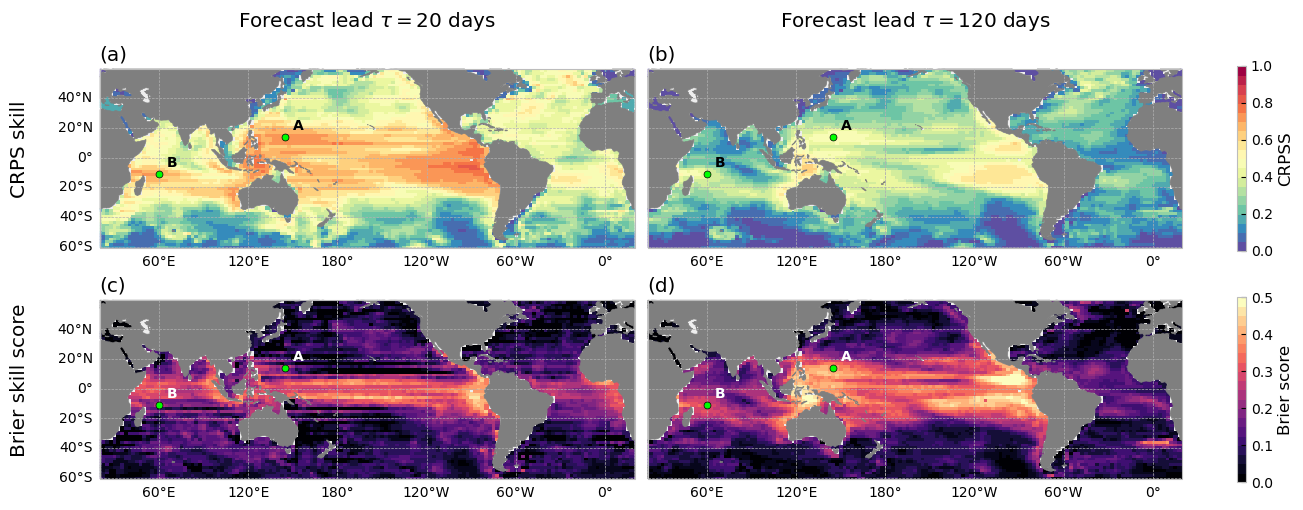

In [8]:
fig, axes = plt.subplot_mosaic(
    [['a', 'b'], ['c', 'd']],
    figsize=(13, 5), 
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)},
    layout='constrained'
)

cax_0 = crps_skill.sel(tau=20).plot(
    ax=axes['a'], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('Spectral_r', 20),
    edgecolor='face',
    add_colorbar=False, vmin=0, vmax=1,
)
cax_0 = crps_skill.sel(tau=120).plot(
    ax=axes['b'], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('Spectral_r', 20),
    edgecolor='face',
    add_colorbar=False, vmin=0, vmax=1,
)
cax_1 = bss.sel(tau=20).plot(
    ax=axes['c'], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('magma', 20),
    edgecolor='face',
    add_colorbar=False, vmin=0, vmax=0.5,
)
cax_1 = bss.sel(tau=120).plot(
    ax=axes['d'], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('magma', 20),
    edgecolor='face',
    add_colorbar=False, vmin=0, vmax=0.5,
)

# Scatter plot
pointlabels = ['A', 'B']
for i, icoord in enumerate(icoords):
    lat, lon = utils.helpers.get_lat_lon_from_icoord(icoord)
    lat = np.round(lat)
    lon = np.round(lon)
    for label, ax in axes.items():
        labelcolor = 'k' if label in ['a', 'b'] else 'w'
        ax.plot(
            [lon], [lat], ls='', marker='.', mfc='lime', ms=10, mec='k',
            mew=0.5, transform=ccrs.PlateCarree(), zorder=4
        )
        ax.text(
            lon+5, lat+5, pointlabels[i], c=labelcolor, fontweight='bold', 
            transform=ccrs.PlateCarree(), zorder=4
        )

# Colorbars
cb = plt.colorbar(
    cax_0, ax=[axes['a'], axes['b']], label='CRPSS', # shrink=0.8, 
    location='right', orientation='vertical')
cb.solids.set_edgecolor('face')

cb = plt.colorbar(
    cax_1, ax=[axes['c'], axes['d']], label='Brier score', # shrink=0.8, 
    location='right', orientation='vertical')
cb.solids.set_edgecolor('face')

for label, ax in axes.items():
    ax.set(title=None)
    ax.add_feature(cartopy.feature.LAND, color='tab:gray', zorder=2)
    gl = ax.gridlines(ls='--', lw=0.5, zorder=3)
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = True # if label in ['e', 'f'] else False
    gl.left_labels = True if label in ['a', 'c', 'e'] else False
    ax.set_title(f'({label})', loc='left')

# Axis labels
for label, tau in zip(['a', 'b'], [20, 120]):
    axes[label].text(
        0.5, 1.2, r'Forecast lead $\tau = {{{}}}$ days'.format(tau),
        va='bottom', ha='center', transform=axes[label].transAxes,
        fontsize='x-large'
    )

axes['a'].text(
    -0.15, 0.55, 'CRPS skill', fontsize='x-large', rotation='vertical',
    va='center', ha='center', transform=axes['a'].transAxes,
)
axes['c'].text(
    -0.15, 0.55, 'Brier skill score', fontsize='x-large', rotation='vertical',
    va='center', ha='center', transform=axes['c'].transAxes,
)

plt.savefig('prob_maps.pdf', dpi=300, bbox_inches='tight')

## Brier score skill

In [17]:
outperform_lr = (bss > 0)
print(outperform_lr.sel(tau=20).mean())
print(outperform_lr.sel(tau=120).mean())

<xarray.DataArray ()>
array(0.6578776)
Coordinates:
    tau      int64 20
<xarray.DataArray ()>
array(0.69986979)
Coordinates:
    tau      int64 120


## Compare CRPS patterns to MAE patterns

In [10]:
def get_errors(tau, conf_threshold=0.2):
    prediction_path = os.path.join(PATHS['full_globe'], 'predictions', f'tau_{tau}')

    target_darray = xr.open_dataarray(os.path.join(prediction_path, 'target.nc'))
    pred_mean_darray = xr.open_dataarray(os.path.join(prediction_path, 'pred_mean.nc'))
    pred_logvar_darray = xr.open_dataarray(os.path.join(prediction_path, 'pred_logvar.nc'))
    linear_darray = xr.open_dataarray(os.path.join(prediction_path, 'dp_pred.nc'))

    mae_ann = np.abs(pred_mean_darray - target_darray).mean(dim='time')
    mae_linear = np.abs(linear_darray - target_darray).mean(dim='time')
    mae_clim = np.abs(target_darray).mean(dim='time')

    # Most confident predictions
    quantile = pred_logvar_darray.quantile(conf_threshold, dim='time')
    conf_preds = pred_mean_darray.where(pred_logvar_darray < quantile, drop=True)
    mae_conf = np.abs(conf_preds - target_darray).mean(dim='time')

    return mae_clim, mae_linear, mae_ann, mae_conf

In [11]:
%%time
mae_clim, mae_linear_20, mae_ann_20, mae_conf_20 = get_errors(tau=20, conf_threshold=0.2)
mae_clim, mae_linear_120, mae_ann_120, mae_conf_120 = get_errors(tau=120, conf_threshold=0.2)

CPU times: user 21.1 s, sys: 9.71 s, total: 30.9 s
Wall time: 39.5 s


In [12]:
xr.corr(crps_skill.sel(tau=20), mae_ann_20)

<xarray.DataArray ()>
array(-0.99422938)
Coordinates:
    tau      int64 20

In [13]:
xr.corr(crps_skill.sel(tau=120), mae_ann_120)

<xarray.DataArray ()>
array(-0.9812369)
Coordinates:
    tau      int64 120

In [14]:
(-0.99422938)**2

0.9884920600551845

In [15]:
0.9812369**2

0.9628258539216099